In [19]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import torch
import numpy as np
from tqdm import tqdm

from AdversarialDatasetUtility import AdversarialDatasetUtility as adu
from VisionModelEvaluator import VisionModelEvaluator

data_path = os.path.join(os.getcwd(), "data")
test_path = os.path.join(data_path, "inputs", "tiny-224", "test")
train_path = os.path.join(data_path, "inputs", "tiny-224", "train")

### 0.1 Getting Started

The goal of the challenge is to develop a program that adds adversarial noise to images with the aim of tricking an image classification model without being detected by a human. 

More formally, consider that $\mathcal{D} = \{ (x_i, y_i) \}_{i=1}^N$ is a dataset of images and their corresponding labels. Let also $f_{\theta}: \mathcal{X} \to \mathcal{Y}$ be a pre-trained image classification model with estimated parameters $\theta$, where $\mathcal{X}$ is the space of images and $\mathcal{Y}$ is the space of labels that achieves $a%$ accuracy a dataset. The goal is to find an adversarial noise $\epsilon$ such that the model misclassifies the image $x_i$:

$$
\epsilon^* = \arg\min_{\epsilon} \frac{1}{N} \sum_{i=1}^N \mathbb{I}\Big(f_{\theta}(x_i + \epsilon) = y_i\Big)
$$

Thus, we have the following model components:

1. **Dataset**: A collection of images and their corresponding labels.
2. **Model**: A pre-trained image classification model that can be used to classify images.
3. **Adversarial Noise**: A perturbation that can be added to the images

This will guide the development of the solution thorough this notebook.

### 0.2 Dataset

The dataset used in this challenge is the 
[Tiny ImageNet]("https://www.kaggle.com/c/tiny-imagenet") dataset, which is a subset of the full ImageNet dataset designed for faster experimentation and academic research. 
Tiny ImageNet contains 200 classes, each corresponding to a WordNet ID (WNID), with 500 training images per class.

The images are color images of size 64×64 pixels, significantly smaller than the 
original ImageNet 224×224 images, making it more manageable for limited compute resources.

The dataset is organized as follows:
- **Training set:** 100,000 images (500 images × 200 classes)
- **Validation set:** 10,000 images (50 images × 200 classes)
- **Test set:** 10,000 images (50 images × 200 classes, labels withheld)

Each class folder contains an <code>images/</code> directory with the raw images and an <code>annotation.txt</code> file describing bounding boxes for the objects. Class code (WNIDs) can be mapped to human-readable class names using the provided <code>words.txt</code> file.

We start by visualizing a few sample images from the dataset to better understand its characteristics and diversity.

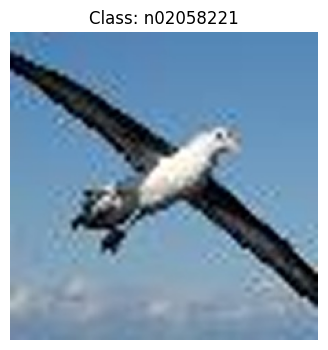

In [20]:
classes = [d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))]

random.seed(19940202)
random_class = random.choice(classes)
images_dir = os.path.join(train_path, random_class, "images")
image_files = os.listdir(images_dir)
random_image_file = random.choice(image_files)
image_path = os.path.join(images_dir, random_image_file)

img = Image.open(image_path).convert("RGB")

plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.title(f"Class: {random_class}")
plt.axis('off')
plt.show()

Below we have the description of each of the classes of the tiny imagenet dataset:

In [21]:
words_path = os.path.join(data_path, "utils", "words.txt")
id_to_label = {}

with open(words_path, 'r') as f:
    for line in f:
        wnid, label = line.strip().split('\t')
        id_to_label[wnid] = label

wnids = sorted([d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))])

print(f"Total classes: {len(wnids)}\n")
for wnid in wnids:
    human_label = id_to_label.get(wnid, "Unknown class")
    print(f"{wnid} -> {human_label}")


Total classes: 200

n01443537 -> goldfish, Carassius auratus
n01629819 -> European fire salamander, Salamandra salamandra
n01641577 -> bullfrog, Rana catesbeiana
n01644900 -> tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui
n01698640 -> American alligator, Alligator mississipiensis
n01742172 -> boa constrictor, Constrictor constrictor
n01768244 -> trilobite
n01770393 -> scorpion
n01774384 -> black widow, Latrodectus mactans
n01774750 -> tarantula
n01784675 -> centipede
n01855672 -> goose
n01882714 -> koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus
n01910747 -> jellyfish
n01917289 -> brain coral
n01944390 -> snail
n01945685 -> slug
n01950731 -> sea slug, nudibranch
n01983481 -> American lobster, Northern lobster, Maine lobster, Homarus americanus
n01984695 -> spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish
n02002724 -> black stork, Ciconia nigra
n02056570 -> king penguin, Aptenodytes patagonica
n02058221 -> albatross, mollyma

### 0.3 Pre-Trained Model

For this challenge, we leverage ImageNet pre-trained models, which are trained on 1,000 object classes from the ImageNet dataset (over 14 million images). These models achieve around 70–80% accuracy on the ImageNet test set.

Although they are not state-of-the-art, they provide an excellent starting point because:

- They learn general visual features that transfer well to new tasks.
- They reduce training time and computational cost via transfer learning.
- They can be fine-tuned on specific tasks with limited data.
- They offer strong baseline performance for image recognition experiments.

This makes them well-suited for the initial phase of the task at hand, before considering more advanced architectures. Among the models we evaluated (AlexNet, ResNet64, and ResNet101) we chose ResNet101 for our experiments due to its superior performance and deeper architecture, which consistently achieved higher accuracy on our Tiny ImageNet evaluation.

Because Tiny ImageNet is a 200-class subset of the original 1,000-class ImageNet dataset, predictions from a pre-trained model must be mapped to the Tiny ImageNet label space before evaluation. Each model output corresponds to an ImageNet 1K index, which can be converted to its WordNet ID (WNID) using the <code>imagenet_class_index.json</code> mapping. Tiny ImageNet labels are also defined using WNIDs, so we align predictions by matching the predicted ImageNet WNID to its corresponding Tiny ImageNet class index (0–199). This ensures that both predictions and ground-truth labels share the same label space for computing accuracy.

In [22]:
dir(models)

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

In [23]:
# transformation for the images
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# load test images
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

# instantiate the vision model evaluator
evaluator = VisionModelEvaluator(
    base_dataset=test_dataset,
    class_index_file=os.path.join(data_path, "utils", "imagenet_class_index.json")
)

# load the pre-trained ResNet-101 model
model = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)

# evaluate the model on the test dataset
all_preds, all_targets = evaluator.fit_vision_model(
    model=model,
    test_dataset=test_dataset,
    batch_size=32,
    shuffle=False
)

# compute test accuracy
acc = evaluator.translate_accuracy(all_preds, all_targets)
print(f"Test accuracy: {acc*100:.2f}%")


Evaluating Model (tag=0.0): 100%|██████████| 157/157 [00:22<00:00,  6.85batch/s]


Test accuracy: 86.20%


### 1.1 Adversarial Noise: Gaussian Noise on Random Pixels

Our first approach to generating adversarial perturbations introduces Gaussian noise to a fixed number of randomly selected pixels in the image. This method is straightforward yet effective for testing a model’s robustness to localized corruption.

The procedure is simple:

- Randomly select a set of pixel coordinates across the image.
- For each selected pixel, add Gaussian noise sampled from $\mathcal{N}(\mu, \sigma^2)$ to all its color channels.
- Optionally, clip the pixel values to the valid range (e.g., $[0,1]$ for normalized images).

This technique is non‑targeted, but it effectively simulates small visual corruptions that can degrade classification performance. As such, it serves as a baseline adversarial noise method before attempting more sophisticated attacks.

We applied this method to a single image while varying the parameters $\mu$ and $\sigma$ to visualize both the visual and predictive effects of the noise. This step is critical because the challenge requires that perturbations remain imperceptible to humans.

Our observations were as follows:

- Effect of $\sigma$: Visual noise becomes noticeable starting at roughly $\sigma > 0.5$.
- Effect of $\mu$: Noise is detectable sooner, from about $\mu > 0.3$, and its impact grows much faster as $\mu$ approaches 1 than when $\sigma$ increases toward 1.
- Effect of the number of perturbed pixels: While increasing the number of noisy pixels does affect detectability, the effect is subtler than changing $\mu$ or $\sigma$, even with a large proportion of pixels altered.

In summary, $\mu$ and $\sigma$ are the dominant factors influencing both detectability and impact on the model, while the number of perturbed pixels plays a secondary role.

After playing out with different values for $\sigma$ and the number of noisy pixels, we found that a noise level of $\sigma = 0.5$ and 6000 noisy pixels per image provided a good balance between imperceptibility and model performance degradation. The pre-trained ResNet101 model degraded from 86% to 85% accuracy on the Tiny ImageNet test set with this noise level.

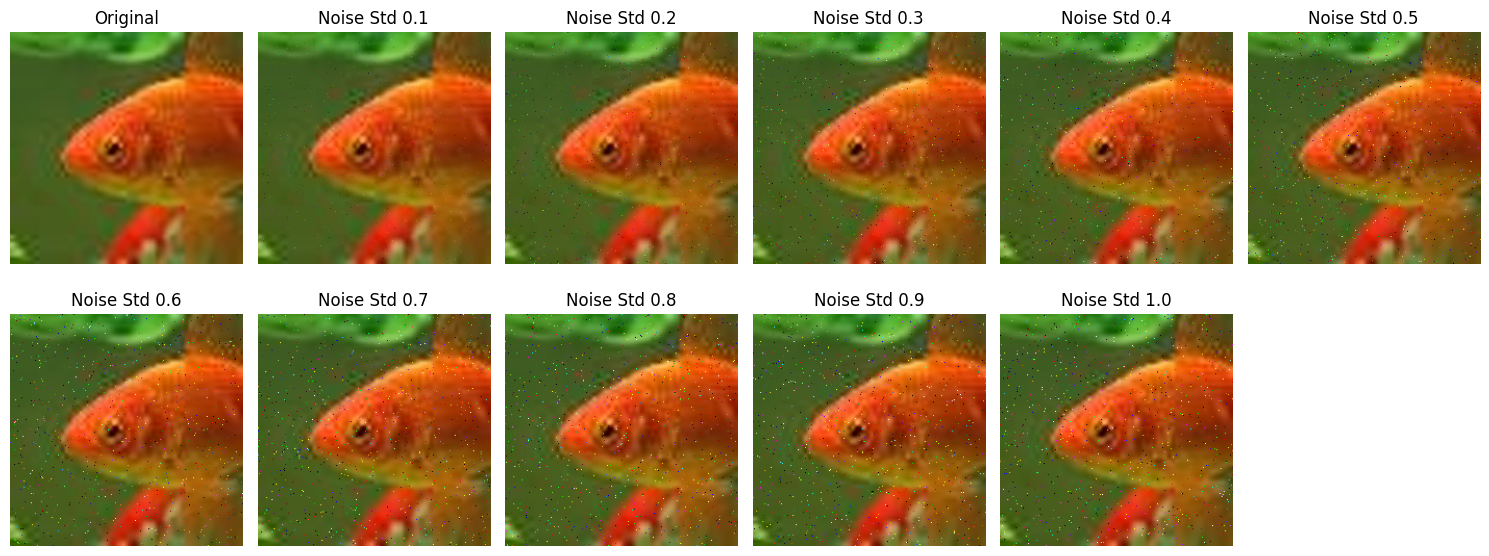

In [24]:
# --- Load test dataset and create DataLoader ---
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Get one batch of images
images, labels = next(iter(test_loader))
i = 1

# Convert the i-th image to (H, W, C) numpy format for visualization
orig_image = images[i].permute(1, 2, 0).numpy()
# Denormalize for proper plotting if needed (ImageNet normalization)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
orig_image = np.clip(orig_image * std + mean, 0, 1)

# Plot original + noisy versions
noise_levels = np.arange(0.1, 1.1, 0.1)  # 0.1 to 1.0 inclusive
num_levels = len(noise_levels)

plt.figure(figsize=(15, 6))

# Plot original
plt.subplot(2, 6, 1)
plt.imshow(orig_image)
plt.title("Original")
plt.axis('off')

# Plot noisy images using the class
for idx, noise_std in enumerate(noise_levels, start=2):
    # Convert original image to torch.Tensor (C,H,W)
    img_tensor = torch.tensor(orig_image).permute(2, 0, 1).float()

    # Apply adversarial noise
    noisy_tensor = adu.add_noise_to_random_pixels(
        img_tensor,
        num_noise_pixels=1000,
        noise_std=noise_std
    )

    # Convert back to numpy for plotting (H, W, C)
    noise_image = noisy_tensor.permute(1, 2, 0).numpy()
    noise_image = np.clip(noise_image, 0, 1)

    plt.subplot(2, 6, idx)
    plt.imshow(noise_image)
    plt.title(f"Noise Std {noise_std:.1f}")
    plt.axis('off')

plt.tight_layout()
plt.show()


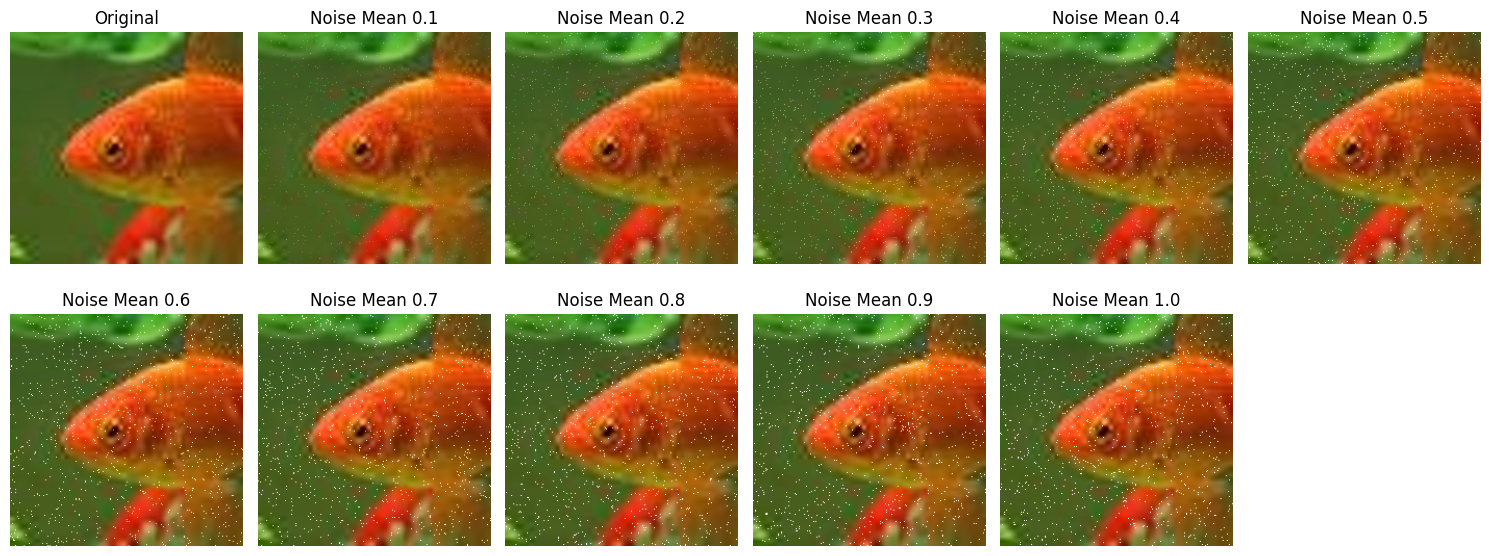

In [25]:
# --- Load test dataset and create DataLoader ---
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Get one batch of images
images, labels = next(iter(test_loader))
i = 1

# Convert the i-th image to (H, W, C) numpy format for visualization
orig_image = images[i].permute(1, 2, 0).numpy()
# Denormalize for proper plotting if needed (ImageNet normalization)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
orig_image = np.clip(orig_image * std + mean, 0, 1)

# Plot original + noisy versions
noise_levels = np.arange(0.1, 1.1, 0.1)  # 0.1 to 1.0 inclusive
num_levels = len(noise_levels)

plt.figure(figsize=(15, 6))

# Plot original
plt.subplot(2, 6, 1)
plt.imshow(orig_image)
plt.title("Original")
plt.axis('off')

# Plot noisy images using the class
for idx, noise_mean in enumerate(noise_levels, start=2):
    # Convert original image to torch.Tensor (C,H,W)
    img_tensor = torch.tensor(orig_image).permute(2, 0, 1).float()

    # Apply adversarial noise
    noisy_tensor = adu.add_noise_to_random_pixels(
        img_tensor,
        num_noise_pixels=1000,
        noise_mean=noise_mean,
        noise_std=0.1
    )

    # Convert back to numpy for plotting (H, W, C)
    noise_image = noisy_tensor.permute(1, 2, 0).numpy()
    noise_image = np.clip(noise_image, 0, 1)

    plt.subplot(2, 6, idx)
    plt.imshow(noise_image)
    plt.title(f"Noise Mean {noise_mean:.1f}")
    plt.axis('off')

plt.tight_layout()
plt.show()


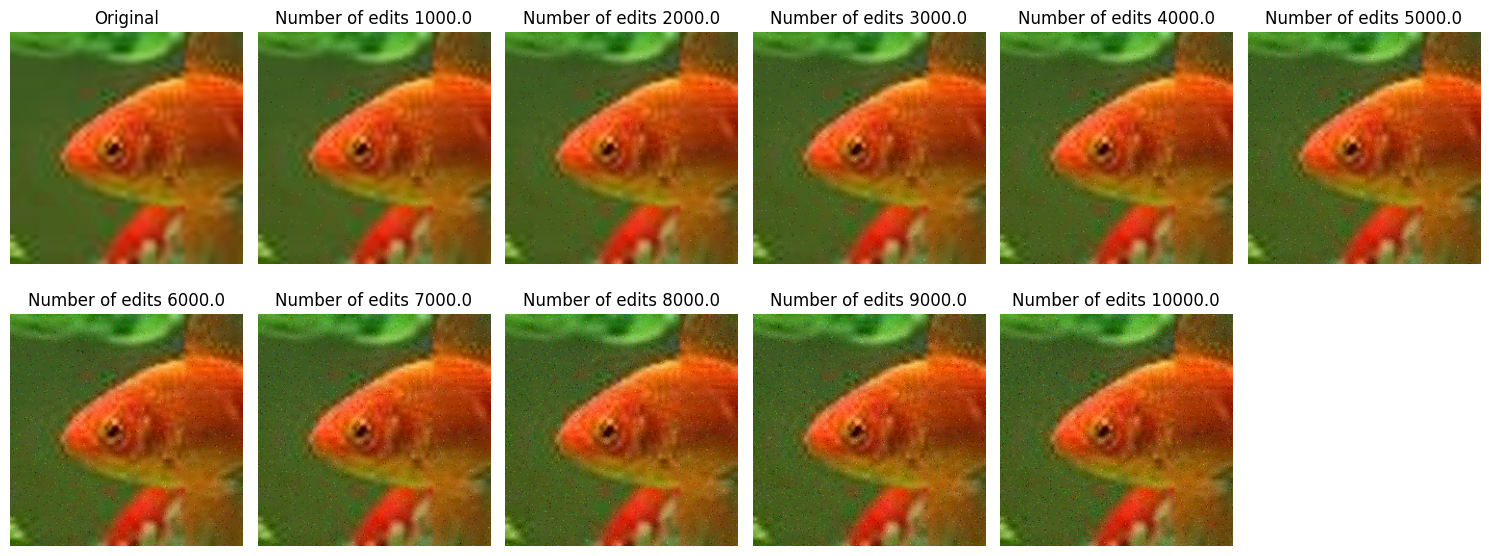

In [26]:
# --- Load test dataset and create DataLoader ---
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Get one batch of images
images, labels = next(iter(test_loader))
i = 1

# Convert the i-th image to (H, W, C) numpy format for visualization
orig_image = images[i].permute(1, 2, 0).numpy()
# Denormalize for proper plotting if needed (ImageNet normalization)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
orig_image = np.clip(orig_image * std + mean, 0, 1)

# Plot original + noisy versions
noise_levels = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
num_levels = len(noise_levels)

plt.figure(figsize=(15, 6))

# Plot original
plt.subplot(2, 6, 1)
plt.imshow(orig_image)
plt.title("Original")
plt.axis('off')

# Plot noisy images using the class
for idx, noise_num in enumerate(noise_levels, start=2):
    # Convert original image to torch.Tensor (C,H,W)
    img_tensor = torch.tensor(orig_image).permute(2, 0, 1).float()

    # Apply adversarial noise
    noisy_tensor = adu.add_noise_to_random_pixels(
        img_tensor,
        num_noise_pixels=noise_num,
        noise_mean=0,
        noise_std=0.1
    )

    # Convert back to numpy for plotting (H, W, C)
    noise_image = noisy_tensor.permute(1, 2, 0).numpy()
    noise_image = np.clip(noise_image, 0, 1)

    plt.subplot(2, 6, idx)
    plt.imshow(noise_image)
    plt.title(f"Number of edits {noise_num:.1f}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [27]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])   
])

# load test dataset
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

# instantiate the vision model evaluator
evaluator = VisionModelEvaluator(
    base_dataset=test_dataset,
    class_index_file=os.path.join(data_path, "utils", "imagenet_class_index.json")
)

# define noise levels
noise_levels = np.arange(0, 0.5, 0.05)

# evaluation loop
for noise_std in noise_levels:
    # load pre-trained model
    model = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)

    # create adversarial (noisy) dataset
    test_dataset_noisy = adu.create_noisy_dataset(
        dataset=test_dataset,
        noise_fn=adu.add_noise_to_random_pixels,
        num_noise_pixels=1000,
        noise_std=noise_std
    )

    # evaluate model
    all_preds, all_targets = evaluator.fit_vision_model(
        model=model,
        test_dataset=test_dataset_noisy,
        batch_size=32,
        shuffle=False,
        tag=noise_std
    )

    # compute translated accuracy
    acc = evaluator.translate_accuracy(all_preds, all_targets)
    print(f"Noise {noise_std:.1f} -> Test accuracy: {acc*100:.2f}%")


Evaluating Model (tag=0.0): 100%|██████████| 157/157 [00:13<00:00, 11.43batch/s]


Noise 0.0 -> Test accuracy: 86.20%


Evaluating Model (tag=0.1): 100%|██████████| 157/157 [00:15<00:00, 10.37batch/s]


Noise 0.1 -> Test accuracy: 86.22%


Evaluating Model (tag=0.1): 100%|██████████| 157/157 [00:14<00:00, 11.15batch/s]


Noise 0.1 -> Test accuracy: 86.06%


Evaluating Model (tag=0.2): 100%|██████████| 157/157 [00:14<00:00, 10.92batch/s]


Noise 0.2 -> Test accuracy: 86.28%


Evaluating Model (tag=0.2): 100%|██████████| 157/157 [00:14<00:00, 11.21batch/s]


Noise 0.2 -> Test accuracy: 85.44%


Evaluating Model (tag=0.2): 100%|██████████| 157/157 [00:14<00:00, 11.14batch/s]


Noise 0.2 -> Test accuracy: 85.79%


Evaluating Model (tag=0.3): 100%|██████████| 157/157 [00:13<00:00, 11.42batch/s]


Noise 0.3 -> Test accuracy: 86.19%


Evaluating Model (tag=0.4): 100%|██████████| 157/157 [00:14<00:00, 11.20batch/s]


Noise 0.4 -> Test accuracy: 85.26%


Evaluating Model (tag=0.4): 100%|██████████| 157/157 [00:14<00:00, 11.09batch/s]


Noise 0.4 -> Test accuracy: 85.63%


Evaluating Model (tag=0.5): 100%|██████████| 157/157 [00:13<00:00, 11.50batch/s]


Noise 0.5 -> Test accuracy: 85.05%


In [30]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])   
])

# load test dataset
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

# instantiate the vision model evaluator
evaluator = VisionModelEvaluator(
    base_dataset=test_dataset,
    class_index_file=os.path.join(data_path, "utils", "imagenet_class_index.json")
)

# define noise levels
noise_nums = [1, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]

# evaluation loop
for noise_num in noise_nums:
    # load pre-trained model
    model = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)

    # create adversarial (noisy) dataset
    test_dataset_noisy = adu.create_noisy_dataset(
        dataset=test_dataset,
        noise_fn=adu.add_noise_to_random_pixels,
        num_noise_pixels=noise_num,
        noise_std=0.1
    )

    # evaluate model
    all_preds, all_targets = evaluator.fit_vision_model(
        model=model,
        test_dataset=test_dataset_noisy,
        batch_size=32,
        shuffle=False,
        tag=noise_num
    )

    # compute translated accuracy
    acc = evaluator.translate_accuracy(all_preds, all_targets)
    print(f"Number of edits {noise_num} -> Test accuracy: {acc*100:.2f}%")


Evaluating Model (tag=1.0): 100%|██████████| 157/157 [00:13<00:00, 11.55batch/s]


Number of edits 1 -> Test accuracy: 86.19%


Evaluating Model (tag=1000.0): 100%|██████████| 157/157 [00:13<00:00, 11.51batch/s]


Number of edits 1000 -> Test accuracy: 85.93%


Evaluating Model (tag=2000.0): 100%|██████████| 157/157 [00:13<00:00, 11.25batch/s]


Number of edits 2000 -> Test accuracy: 85.90%


Evaluating Model (tag=3000.0): 100%|██████████| 157/157 [00:13<00:00, 11.61batch/s]


Number of edits 3000 -> Test accuracy: 86.10%


Evaluating Model (tag=4000.0): 100%|██████████| 157/157 [00:15<00:00, 10.39batch/s]


Number of edits 4000 -> Test accuracy: 85.92%


Evaluating Model (tag=5000.0): 100%|██████████| 157/157 [00:15<00:00,  9.94batch/s]


Number of edits 5000 -> Test accuracy: 86.40%


Evaluating Model (tag=6000.0): 100%|██████████| 157/157 [00:13<00:00, 11.26batch/s]


Number of edits 6000 -> Test accuracy: 85.60%


Evaluating Model (tag=7000.0): 100%|██████████| 157/157 [00:14<00:00, 11.21batch/s]


Number of edits 7000 -> Test accuracy: 85.76%


Evaluating Model (tag=8000.0): 100%|██████████| 157/157 [00:13<00:00, 11.40batch/s]


Number of edits 8000 -> Test accuracy: 85.75%


Evaluating Model (tag=9000.0): 100%|██████████| 157/157 [00:14<00:00, 10.69batch/s]


Number of edits 9000 -> Test accuracy: 86.39%


Evaluating Model (tag=10000.0): 100%|██████████| 157/157 [00:13<00:00, 11.27batch/s]

Number of edits 10000 -> Test accuracy: 86.04%


In [31]:
# load pre-trained model
model = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)

# create adversarial (noisy) dataset
test_dataset_noisy = adu.create_noisy_dataset(
    dataset=test_dataset,
    noise_fn=adu.add_noise_to_random_pixels,
    num_noise_pixels=6000,
    noise_std=0.5
)

# evaluate model
all_preds, all_targets = evaluator.fit_vision_model(
    model=model,
    test_dataset=test_dataset_noisy,
    batch_size=32,
    shuffle=False,
    tag=noise_std
)

# compute translated accuracy
acc = evaluator.translate_accuracy(all_preds, all_targets)
print(f"Noise {noise_std:.1f} -> Test accuracy: {acc*100:.2f}%")

Evaluating Model (tag=0.5): 100%|██████████| 157/157 [00:14<00:00, 11.11batch/s]

Noise 0.5 -> Test accuracy: 84.98%
